# Injecting and detecting strongly-lensed objects in images

<img align="left" src = https://noirlab.edu/public/media/archives/logos/svg/logo250.svg width=250 style="background-color:white; padding:10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">

<br>
For the Rubin Science Platform at data.lsst.cloud. <br>
LSST Science Pipelines version: Weekly 2025_09 <br>
Container Size: Medium <br>
Data Release: DP0.2 <br>
Last verified to run: 2025-03-07 <br>

**Learning objective:**
Inject known strongly-lensed objects into an image, and then detect, deblend, and measure the lens and the lensed sources.
Understand deblending concepts of parents and children, and flux measurement and shape parameters relevant to lensed arcs.

**LSST data products:**
`calexp` image, `source` table

**Packages:**
`lsst.daf`, `lsst.afw`, `lsst.source.injection`, `lsst.pipe.tasks`, `lsst.meas`

**Credit:**
Based on DP0.2 tutorial notebooks originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

Strong lensing occurs when a 1) foreground galaxy is aligned with a background galaxy, 2) those two objects are close enough, and 3) the lensing foreground galaxy is sufficiently massive.

The foreground galaxy perceptibly distorts the light from the background galaxy, and the background galaxy appears magnified and multiply-imaged, or as an arc or ring, instead of its true shape.

In this case, the background galaxy is said to be "strongly lensed".

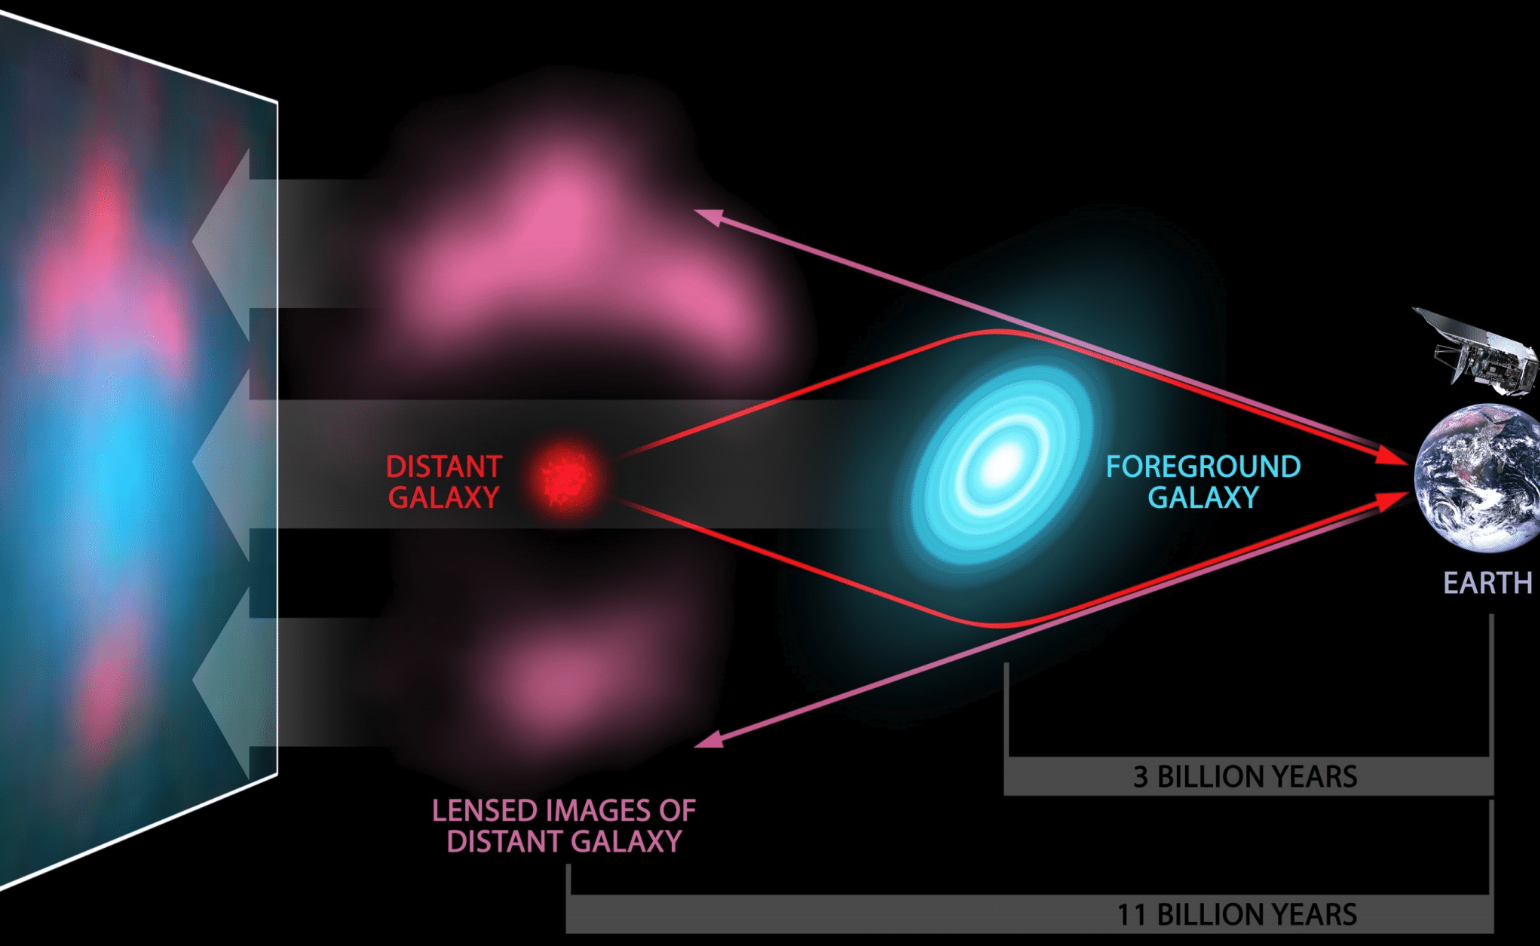

>**Figure 1:** A graphic demonstrating how a distant galaxy (red) appears distorted (pink) due to the mass of a foreground galaxy (blue) from Earth's perspective (right side), and appears as a strongly-lensed object in an image (left side).

**Deriving physical parameters from strong lensing measurements.**

From the apparent angular separation and distortion of the background galaxy and the foreground lens, and the distances between these two objects and the observer, the total mass of the foreground galaxy - including dark matter - can be derived.

Thus, the relevant measured parameters for strong lensing science include the location, shape, and brightness (astrometry and photometry) of the galaxies and their photometric redshift.

For the purposes of this demonstration, the combined image of a famous foreground lens galaxy and background strongly-lensed galaxy called the Cosmic Horseshoe are injected into a single simulated LSST exposure.

Then source detection, deblending, and measurement are run on the exposure to create catalog data products that include lenses and lensed objects.

**The term "source" has multiple meanings.**

In the field of strong lensing, the term "source" refers to the background galaxy.

In the Rubin data products - and in this tutorial - the term "source" refers to a detection in a visit image.

**Data Preview 0.2 vs. Data Preview 1**

In the Data Preview 0.2 (DP0.2) simulation there are no strongly-lensed objects, like there will be in the real data released as Data Preview 1 (DP1), which is why this tutorial uses source injection.

Note that for DP1 the exact types of measurements and their column names are likely to be different, compared to DP0.
The LSST Science Pipelines have evolved considerably since being run on the DP0.2 simulation. 

**This is not an introductory-level tutorial!**
Find tutorials on how to use Jupyter Notebooks, the data butler, and image display tools in the [DP0.2 documentation](dp0-2.lsst.io).

**Related tutorials relevant to strong lensing science.**
See also the DP0.2 tutorial notebooks on source detection and measurement, synthetic source injection, and the bulk image cutout tool.

### 1.1. Import packages

Import general science and astronomy packages, and specific packages from the [LSST Science Pipelines](https://pipelines.lsst.io/).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table , vstack
import lsst.geom as geom
from lsst.daf.butler import Butler
import lsst.daf.base as dafBase
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
import lsst.afw.table as afwTable
from lsst.source.injection import generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

### 1.2. Define parameters and functions

Set `afwDisplay` to use Firefly for image display.

In [ ]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.Display(frame=1)

Instantiate the data butler.

In [ ]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

Create a function to rotate an image (`exposure`) clockwise by `angle` degrees.

In [ ]:
def rotate_exposure(exposure, angle):
    """Rotate an exposure by an angle in degrees, clockwise.

    Parameters
    ----------
    exposure : `lsst.afw.image.exposure.Exposure`
        The exposure to rotate.
    angle : `float`
        Number of degrees clockwise to rotate by.

    Returns
    -------
    rotated_exposure : `lsst.afw.image.exposure.Exposure`
        A copy of the input exposure, rotated by the angle.
    """
    
    angle = angle % 360
    wcs = exposure.getWcs()
    warper = afwMath.Warper('lanczos4')
    affine_rot_transform = geom.AffineTransform.makeRotation(angle*geom.degrees)
    transform_p2top2 = afwGeom.makeTransform(affine_rot_transform)
    rotated_wcs = afwGeom.makeModifiedWcs(transform_p2top2, wcs, False)
    rotated_exposure = warper.warpExposure(rotated_wcs, exposure)
    
    return rotated_exposure

## 2. Get a stamp of a known lensed object

"Stamp" is a term for a small cutout image, typically containing just one object.

This demo requires a stamp of a known lensed object, and uses the [Cosmic Horseshoe](https://en.wikipedia.org/wiki/Cosmic_Horseshoe). 

The DESI Legacy Imaging Surveys interactive website, [legacysurvey.org](https://www.legacysurvey.org/) was used to obtain an r-band cutout of the Cosmic Horseshoe ([instructions](https://www.legacysurvey.org/viewer/urls) and [tips](https://www.legacysurvey.org/svtips/)).

This is the exact URL used to create the cutout.
```
https://www.legacysurvey.org/viewer/fits-cutout?ra=177.13808333&dec=19.50088889&pixscale=0.262&layer=decals-dr7&size=55&bands=r
```

After download, the cutout was renamed "cosmic_horseshoe.fits".

Use the `fits` package to read the image stamp, then display it in the Firefly window.

In [ ]:
stamp_filename = 'cosmic_horseshoe.fits'
stamp_expF = afwImage.ExposureF.readFits(stamp_filename)
afw_display.mtv(stamp_expF)

### 2.1. Rotate the stamp

Use the `rotate_exposure` function to rotate the stamp by 90, 180, and 270 degrees.

When the image is rotated, the "empty" pixels are given NaN values.
Replace those with zeros before writing to file.
If they are left as NaNs, the image values will not be read correctly.

Save the rotated stamps as new fits files.

In [ ]:
stamp_expF = afwImage.ExposureF.readFits(stamp_filename)
angles = np.asarray([90, 180, 270], dtype='int')
for angle in angles:
    str_angle = str(angle)
    filename = 'cosmic_horseshoe_' + str_angle + '.fits'
    if os.path.exists(filename):
        print('Exists: ', filename)
    else:
        stamp_expF_rot = rotate_exposure(stamp_expF, angle)
        stamp_expF_rot.image.array[np.where(np.isnan(stamp_expF_rot.image.array))] = 0.0
        stamp_expF_rot.writeFits(filename)
        del stamp_expF_rot
    del str_angle, filename
del angles, stamp_expF

## 3. Get an image to inject galaxies into

Define the `dataId` for an r-band image of type `calexp`, and use the butler to retrieve it.

In [ ]:
dataId = {'instrument': 'LSSTCam-imSim', 'detector': 19, 'visit': 213513,
          'band': 'r'}
calexp = butler.get('calexp', dataId=dataId)

Display the `calexp` in Firefly.
Set the image mask to be 100% transparent.

In [ ]:
afw_display.mtv(calexp)

In [ ]:
afw_display.setMaskTransparency(100)

Use the `calexp`'s WCS and bounding box (`bbox`) to get the center coordinates and the size in degrees.

Set the `radius` within which to inject fake sources to be well within the image boundaries by dividing by 3.

In [ ]:
wcs = calexp.getWcs()
bbox = calexp.getBBox()
center = wcs.pixelToSky(bbox.getCenter())
ra_cen = center.getRa().asDegrees()
dec_cen = center.getDec().asDegrees()
size = bbox.getDimensions()[0]*wcs.getPixelScale().asDegrees()
radius = size / 3.0
print(ra_cen, dec_cen)
print(size, radius)
del wcs, bbox, center, size

## 4. Inject sources into the calexp

### 4.1. Regular galaxies

Use the `generate_injection_catalog` function to create a set of synthetic galaxies with a range of parameters.

**Coordinates**

Set the `ra_lim` and `dec_lim` ranges within which the simulated galaxies will be distributed using the image center and radius defined above.

**Shape**

Use a `source_type` for a [Sersic model](https://en.wikipedia.org/wiki/S%C3%A9rsic_profile), in which the galaxy's light profile is defined by $I(r) = I_e~{\rm exp}\{-b_n [(\frac{r}{r_e})^{1/n}-1]\}$ where $r$ is radius in terms of the "Sersic index" ($n$) and the "half-light radius" ($r_e$).

A value of $n = 1$ corresponds to an exponential profile, for which the light is less centrally concentrated than higher values of $n$.
Choose to use to values of `n`, 1 and 2, and `half_light_radius` values of 10 and 30 arcseconds.

To create elongated (elliptical) Sersic profiles, specify the minor-to-major axis ratio ($q$) with a rotation angle (beta).
Choose to use two values of `q`, 0.7 and 0.3, and two angles for `beta`, 90 and 120 degrees.

**Magnitude**

Choose to use two values of `mag`, 18 and 21.

**Number**

Specify `number` = 1 to create 1 synthetic galaxy for each permutation. 

All together, with two values for each of the five parameters, $2^5 = 32$ synthetic galaxies will be generated.

In [ ]:
my_injection_catalog = generate_injection_catalog(
    ra_lim=[ra_cen - radius, ra_cen + radius],
    dec_lim=[dec_cen - radius, dec_cen + radius],
    source_type="Sersic",
    n=[1, 2],
    half_light_radius=[10.0, 30.0],
    q=[0.7, 0.3],
    beta=[90.0, 120.0],
    mag=[18, 21],
    number=1,
    seed='3210')

Option to display the catalog.

In [ ]:
# my_injection_catalog

### 4.2. The Cosmic Horseshoe

Generate a set of 32 random locations, magnitudes, and rotations for the stamp of the Cosmic Horseshoe.

* Start the `id` values at 100.
* Create a uniforn distribution of random coordinates `ras` and `decs` within the defined radius of the center.
* Create a uniform distribution of random magnitude values `mags` between 18 and 21 mag.
* Create a list of rotation values to use by choosing from the 4 options 32 times with replacement.

Add rows to the injection catalog using the `vstack` function.

In [ ]:
id_value = 99
ras = np.random.uniform(low=ra_cen-radius, high=ra_cen+radius, size=32)
decs = np.random.uniform(low=dec_cen-radius, high=dec_cen+radius, size=32)
mags = np.random.uniform(low=18, high=21, size=32)
rxs = np.random.choice(4, size=32, replace=True)
rots = np.asarray(['', '_90', '_180', '_270'], dtype='str')

for i in range(32):
    id_value += 1
    filename = 'cosmic_horseshoe' + rots[rxs[i]] + '.fits'
    my_injection_stamp = Table(
        {'injection_id': [id_value],
         'ra': [ras[i]],
         'dec': [decs[i]],
         'source_type': ['Stamp'],
         'mag': [mags[i]],
         'stamp': [filename]})
    if i == 0:
        inject_cat = vstack([my_injection_catalog, my_injection_stamp])
    else:
        inject_cat = vstack([inject_cat, my_injection_stamp])
    
    del filename
    
del id_value, ras, decs, mags, rxs, rots

Option to view the amalgamated injection catalog.

In [ ]:
# inject_cat

### 4.3. Injection

Get the `psf` (point-spread function), the photometric calibration, and WCS of the image.

In [ ]:
psf = calexp.getPsf()
photo_calib = calexp.getPhotoCalib()
wcs = calexp.getWcs()

Instantiate the `VisitInjectTask` with a default configuration.

In [ ]:
inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

Run the source injection.

In [ ]:
injected_output = inject_task.run(
    injection_catalogs=inject_cat,
    input_exposure=calexp.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs)
injected_exposure = injected_output.output_exposure
injected_catalog = injected_output.output_catalog

Clone the resulting image with sources injected.

In [ ]:
injected_calexp = injected_exposure.clone()

## 5. Analyze injected sources

### 5.1. Display image with injected sources

Display the `calexp` with injected sources and mark each with a circle.

In [ ]:
afw_display.mtv(injected_calexp)

In [ ]:
afw_display.setMaskTransparency(100)

In [ ]:
with afw_display.Buffering():
    for row in inject_cat:
        coord = geom.SpherePoint(row.get('ra')*geom.degrees,
                                 row.get('dec')*geom.degrees)
        xy = wcs.skyToPixel(coord)
        stype = row.get('source_type')
        clr = 'cyan'
        if stype == 'Stamp':
            clr = 'orange'
        afw_display.dot('o', xy[0], xy[1], size=50, ctype=clr)
        del coord, xy, stype, clr

### 5.2. Run tasks to detect sources

The four tasks to be run will:
* characterize the image (i.e., measure PSF)
* detect sources in the image
* deblend the detected sources
* measure the detected sources

**Deblend** means to separate individual sources that are very close or even overlapping in the image.
A blended source is called a "**parent**" and the deblended, individual sources are called "**children**".

The order of operations is:
* create inputs (schema, configs)
* instantiate and configure each task
* run each task in turn

#### 5.2.1. Create inputs for the tasks

Make a minimal schema, and add the needed `coord_raErr` and `coord_decErr` columns.

In [ ]:
schema = afwTable.SourceTable.makeMinimalSchema()
raerr = schema.addField("coord_raErr", type="F")
decerr = schema.addField("coord_decErr", type="F")

Create a container which will be used to record metadata about algorithm execution.

In [ ]:
algMetadata = dafBase.PropertyList()

#### 5.2.2. Instantiate and configure tasks

Configure the task to characterize the image to only do one iteration on the PSF.

In [ ]:
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)
del config

Configure the task to detect sources to use a threshold of 4 times the standard deviation.

In [ ]:
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 5
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
del config

No special configuration is needed for the task to deblend detected sources.

In [ ]:
sourceDeblendTask = SourceDeblendTask(schema=schema)

Use the default configuration for the task to make measurements of the detected and deblended sources.

In [ ]:
config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)
del config

Create a source table named `tab` using the minimal schema.
This source table will hold the output of the tasks.

In [ ]:
tab = afwTable.SourceTable.make(schema)
del schema

Rename the injected exposure as simply the `calexp` to be passed to the tasks.

In [ ]:
calexp = injected_exposure.clone()

#### 5.2.3. Run each task


In [ ]:
result = charImageTask.run(calexp)

In [ ]:
result = sourceDetectionTask.run(tab, calexp)

Create `sources` to hold the detected sources from the results.

In [ ]:
sources = result.sources

In [ ]:
sourceDeblendTask.run(calexp, sources)

In [ ]:
sourceMeasurementTask.run(measCat=sources, exposure=calexp)

Ensure that the `sources` catalog is contiguous (sequential) in memory by making a copy.

In [ ]:
sources = sources.copy(True)

In [ ]:
print(len(sources))

Option to view `sources` in astropy table format.

In [ ]:
# sources.asAstropy()

Options to print all column names, or only column names containing a given string like "Shape".

In [ ]:
# sources_schema = sources.columns.getSchema()
# for colname in sources_schema.getNames():
#     print(colname)

In [ ]:
# for colname in sources_schema.getNames():
#     if colname.find('Shape') > 0:
#         print(colname)

### 5.3. Mark all detected sources on image

Mark all detected sources with a small red circle.

In [ ]:
with afw_display.Buffering():
    for s in sources:
        afw_display.dot('o', s.getX(), s.getY(),
                        size=10, ctype='red')

Zoom in on some of the orange circles to see how the lens (foreground galaxy) and strongly-lensed object (background galaxy) were detected.

That is a lot of detections, and it includes all detected "parent" sources plus each of the deblended "children".

Explore the number of parents and children.

In [ ]:
nchildren = np.asarray(sources['deblend_nChild'], dtype='int')
tx = np.where(nchildren > 0)[0]
print('Number of parents: ', len(tx))
print('Minimum and maximum number of children per parent: ',
      min(nchildren[tx]), max(nchildren[tx]))

fig = plt.figure(figsize=(6, 3))
plt.hist(nchildren[tx],
         bins=np.arange(min(nchildren[tx]),
                        max(nchildren[tx]) + 1, 1),
         histtype='step', log=True)
plt.xlabel('number of children per parent')
plt.ylabel('number of parents')
plt.show()

> Figure 1: The distribution of the number of parents with X children.

Clear the markers.

In [ ]:
afw_display.erase()

Mark only the injected stamps of the Cosmic Horseshoe.

In [ ]:
with afw_display.Buffering():
    for row in inject_cat:
        coord = geom.SpherePoint(row.get('ra')*geom.degrees,
                                 row.get('dec')*geom.degrees)
        xy = wcs.skyToPixel(coord)
        stype = row.get('source_type')
        if stype == 'Stamp':
            afw_display.dot('o', xy[0], xy[1],
                            size=50, ctype='orange')
        del coord, xy, stype

Mark only parent sources.

In [ ]:
with afw_display.Buffering():
    for s in sources:
        n = s.get('deblend_nChild')
        if n > 0:
            afw_display.dot('o', s.getX(), s.getY(),
                            size=30, ctype='red')

Notice that some detections of the Cosmic Horseshoe are marked with red circles as parents, indicating that they were detected and that they were deblended into parent and child sources.

Some detections of the Cosmic Horeshoe are not marked with red circles, indicating that they were detected as single undeblendable source (or not at all).

This will be explored in further depth below.

Clear all markers.

In [ ]:
afw_display.erase()

### 5.4. Explore which injected stamps are detected

For the purposes of this demonstration, consider an injected stamp "detected" if there is a detected source within 10 pixels (2 arcseconds).
The actual cross-matching threshold for a real scientific analysis should take into consideration the required completeness or purity of the analysis.

Create columns in `inject_cat` to hold information from `sources` about the nearest detected source within 10 pixels.

In [ ]:
inject_cat['source_x'] = np.zeros(len(inject_cat), dtype='float')
inject_cat['source_y'] = np.zeros(len(inject_cat), dtype='float')
inject_cat['source_id'] = np.zeros(len(inject_cat), dtype='int') - 1
inject_cat['source_dnC'] = np.zeros(len(inject_cat), dtype='int')

Extract the detected sources' pixel coordinates, identifiers, and `deblend_nChild` values as `numpy` arrays.

In [ ]:
source_x = np.zeros(len(sources), dtype='float')
source_y = np.zeros(len(sources), dtype='float')
source_id = np.zeros(len(sources), dtype='int')
source_dnC = np.zeros(len(sources), dtype='int')

for i, s in enumerate(sources):
    source_x[i] = s.getX()
    source_y[i] = s.getY()
    source_id[i] = s.get('id')
    source_dnC[i] = s.get('deblend_nChild')

For each injected stamp of the Cosmic Horeshoe, calculate the distance to all detected sources, as `radii` in pixels.

If there are parent galaxies with `deblend_nChild` > 0 within 10 pixels, use the closest one as the match.

If there are no parents within 10 pixels, but the nearest source is within 10 pixels, take that as the match.

Store the matching source's information in the new columns of `inject_cat`.

In [ ]:
for i, row in enumerate(inject_cat):
    coord = geom.SpherePoint(row.get('ra')*geom.degrees,
                             row.get('dec')*geom.degrees)
    xy = wcs.skyToPixel(coord)
    stype = row.get('source_type')
    if stype == 'Stamp':
        sx = -1
        radii = np.sqrt((source_x - xy[0])**2 + 
                        (source_y - xy[1])**2)
        px = np.where((radii <= 10.0) &
                      (source_dnC > 0))[0]
        if len(px) > 0:
            mx = np.argmin(radii[px])
            sx = px[mx]
        elif len(px) == 0:
            mx = np.argmin(radii)
            if radii[mx] <= 10.0:
                sx = mx
        inject_cat['source_x'][i] = source_x[sx]
        inject_cat['source_y'][i] = source_y[sx]
        inject_cat['source_id'][i] = source_id[sx]
        inject_cat['source_dnC'][i] = source_dnC[sx]

Option to review the new columns (scroll all the way right).

In [ ]:
# inject_cat

Again mark only the injected stamps of the Cosmic Horseshoe.

In [ ]:
with afw_display.Buffering():
    for row in inject_cat:
        coord = geom.SpherePoint(row.get('ra')*geom.degrees,
                                 row.get('dec')*geom.degrees)
        xy = wcs.skyToPixel(coord)
        stype = row.get('source_type')
        if stype == 'Stamp':
            afw_display.dot('o', xy[0], xy[1],
                            size=30, ctype='orange')
        del coord, xy, stype

Mark the coordinates for corresponding detected sources, with a circle size that corresponds to the number of children.
Store the `source_id` of matched parents in `parent_ids`.

In [ ]:
temp1 = []
with afw_display.Buffering():
    for row in inject_cat:
        stype = row.get('source_type')
        if stype == 'Stamp':
            sid = row.get('source_id')
            sdnC = row.get('source_dnC')
            if sid >= 0:
                simsize = 40 + sdnC*5
                afw_display.dot('o',
                                row['source_x'],
                                row['source_y'],
                                size=simsize,
                                ctype='red')
                if sdnC > 0:
                    temp1.append(sid)
                del simsize
            del sid, sdnC
        del stype
parent_ids = np.asarray(temp1, dtype='int')
del temp1
print('Number of parents matched to injected stamps: ', len(parent_ids))

For each injected stamp of the Cosmic Horseshoe that was detected as a parent with children, mark the children as white circles.

In [ ]:
with afw_display.Buffering():
    for s in sources:
        pid = s.get('parent')
        tx = np.where(pid == parent_ids)[0]
        if len(tx) > 0:
            afw_display.dot('o', s.getX(), s.getY(),
                            size=10, ctype='white')

Zoom in to take a closer look at how the arcs of the lensed background galaxies are, in many cases, deblended into multiple children.

### 5.5. Flux and shape of lensed arc sources

Flux and shape measurements in the source catalog could be used to identify or analyze lensed sources.
For this demonstration, simple measurements of source flux and ellipticity are taken from the source catalog and analyzed.

Convert the second-order moment shape parameters into an ellipticity measurement (`source_ell`) following this description and graphic of the ellipse parameters CXX, CYY, CXY in the [Source Extractor documentation](https://sextractor.readthedocs.io/en/latest/Position.html#isophotal-measurements) by E. Bertin.
Also put the `source_flux` into a `numpy` array.

Set a "not a parent" flag (`source_npflag`) to 1 if the detected source has no children (is not a parent).
Set a "is a child of a parent matched to a Cosmic Horseshoe" flag (`source_pCHflag`) if the detected source is the child of a parent that was matched to an injected stamp.

> **Warning:** the following cell produces a pink "RuntimeWarning" due to attempted square roots of negative values. It is ok to ignore for this demo, but should be investigated in any real scientific analysis.

In [ ]:
source_ell = np.zeros(len(sources), dtype='float')
source_flux = np.zeros(len(sources), dtype='float')
source_npflag = np.zeros(len(sources), dtype='int')
source_pCHflag = np.zeros(len(sources), dtype='int')

for i, s in enumerate(sources):
    Ixx = s.get('base_SdssShape_xx')
    Iyy = s.get('base_SdssShape_yy')
    Ixy = s.get('base_SdssShape_xy')
    temp1 = (Ixx + Iyy)/2.0
    temp2 = np.sqrt(((Ixx - Iyy)/2.0)**2 + (Ixy)**2)
    A = np.sqrt(temp1 + temp2)
    B = np.sqrt(temp1 - temp2)
    source_ell[i] = 1.0 - (B/A)
    del Ixx, Iyy, Ixy, temp1, temp2, A, B

    source_flux[i] = s.get('base_SdssShape_instFlux')

    dnC = s.get('deblend_nChild')
    if dnC == 0:
        source_npflag[i] = 1
    pid = s.get('parent')
    tx = np.where(pid == parent_ids)[0]
    if len(tx) > 0:
        source_pCHflag[i] = 1
    del dnC, pid, tx

Plot flux vs. ellipticiy.

In [ ]:
fig = plt.figure(figsize=(6, 3))
tx = np.where(source_npflag == 1)[0]
plt.plot(np.log10(source_flux[tx]), source_ell[tx], 'o',
         ms=3, mew=0, alpha=0.3, color='grey',
         label='non-parents')
del tx
tx = np.where(source_pCHflag == 1)[0]
plt.plot(np.log10(source_flux[tx]), source_ell[tx], 'o',
         ms=3, mew=0, alpha=1, color='black',
         label='children of the C.H.')
del tx
plt.xlabel('log(flux)')
plt.ylabel('ellipticity')
plt.legend(loc='upper right')
plt.show()

> Figure 2: The log of the flux versus the ellipticity for all non-parent sources (grey) and all children of parent sources matched to the Cosmic Horseshoe injected stamps (black).
The "regular galaxies" (grey) and "potentially lensed arcs" (black) exhibit different distributions in the two-dimensional space of ellipticity and flux.